[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--2024-12-19 18:48:19--  https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/blob/main/SpamEmailClassificationDataset.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/raw/refs/heads/main/SpamEmailClassificationDataset.zip [following]
--2024-12-19 18:48:19--  https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/raw/refs/heads/main/SpamEmailClassificationDataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/refs/heads/main/SpamEmailClassificationDataset.zip [following]
--2024-12-19 18:48:20--  https://raw.githubusercontent.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/refs/heads/main/SpamEmailClassificationDataset.zip
Res

<ipython-input-18-160ae6e0f2c1>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='coolwarm')


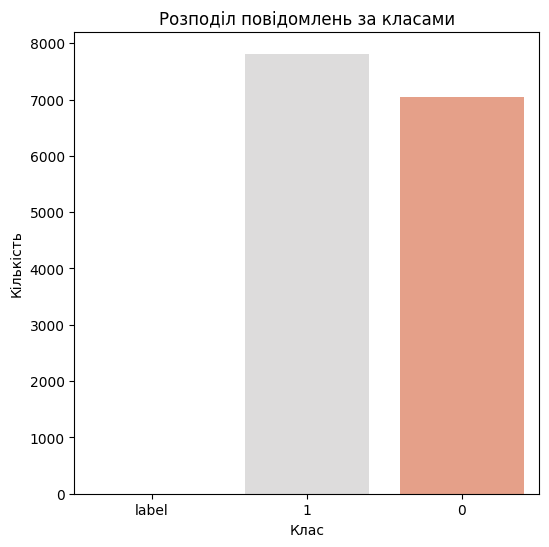

Кількість повідомлень по класах після фільтрації:
label
1    7813
0    7047
Name: count, dtype: int64
Точність класифікації: 94.92%

Повний звіт про класифікацію:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1409
           1       0.96      0.94      0.95      1563

    accuracy                           0.95      2972
   macro avg       0.95      0.95      0.95      2972
weighted avg       0.95      0.95      0.95      2972


Топ 10 слів, характерних для спаму:
best: 0.0021
buy: 0.0021
hk: 0.0021
offer: 0.0021
day: 0.0024
escapelong: 0.0025
price: 0.0031
com: 0.0034
http: 0.0039
escapenumber: 0.0040

Топ 10 слів, характерних для звичайних повідомлень:
mailing: 0.0023
subject: 0.0023
wrote: 0.0024
help: 0.0026
http: 0.0027
escapenumber: 0.0027
thanks: 0.0028
list: 0.0028
please: 0.0033
org: 0.0034

Висновки:
1. Модель показала високу точність класифікації (94.92%), що вказує на ефективність використаного наївного класифікатора

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer

# Завантаження бібліотек NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Завантаження даних
!wget -O SpamEmailClassificationDataset.zip https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/blob/main/SpamEmailClassificationDataset.zip?raw=true
!unzip -o SpamEmailClassificationDataset.zip

# Завантаження CSV файлу
df = pd.read_csv('./SpamEmailClassificationDataset/combined_data.csv')

# Перевірка кількості класів
print("Кількість повідомлень по класах:")
print(df['label'].value_counts())

# Візуалізація розподілу класів
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='label', palette='coolwarm')
plt.title('Розподіл повідомлень за класами')
plt.xlabel('Клас')
plt.ylabel('Кількість')
plt.show()

# Фільтрація для класів із мінімальною кількістю записів >= 2
df = df.groupby('label').filter(lambda x: len(x) >= 2)

# Перевірка після фільтрації
print("Кількість повідомлень по класах після фільтрації:")
filtered_counts = df['label'].value_counts()
print(filtered_counts)

if len(filtered_counts) < 2 or min(filtered_counts) < 2:
    raise ValueError("Недостатньо даних для обох класів після фільтрації.")

# Функція для попередньої обробки тексту
def preprocess_text(text):
    # Перетворення на малі літери
    text = text.lower()
    # Видалення пунктуації та чисел
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Видалення зайвих пробілів
    text = ' '.join(text.split())
    return text

# Функція для тренування моделі на спамових листах
def train_spam(data, vectorizer, model):
    spam_data = data[data['label'] == 'spam']['text']
    spam_data = spam_data.apply(preprocess_text)
    X_spam = vectorizer.fit_transform(spam_data)
    y_spam = ['spam'] * len(spam_data)
    model.fit(X_spam, y_spam)

# Функція для тренування моделі на нормальних (не спамових) листах
def train_ham(data, vectorizer, model):
    ham_data = data[data['label'] == 'ham']['text']
    ham_data = ham_data.apply(preprocess_text)
    X_ham = vectorizer.transform(ham_data)
    y_ham = ['ham'] * len(ham_data)
    model.partial_fit(X_ham, y_ham, classes=['ham', 'spam'])

# Функція для тестування нових листів
def test_emails(data, vectorizer, model):
    test_data = data['text'].apply(preprocess_text)
    X_test = vectorizer.transform(test_data)
    y_test = data['label']
    predictions = model.predict(X_test)
    return classification_report(y_test, predictions)

# Попередня обробка тексту: лематизація та видалення стоп-слів
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_advanced_text(text):
    text = re.sub("[^a-zA-Z]", " ", text).lower()  # Видалення небуквових символів
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Лематизація
    words = list(set(words))  # Видалення повторів
    return " ".join(words)

df["text"] = df["text"].apply(preprocess_advanced_text)

# Поділ даних на тренувальні та тестові набори
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# Ініціалізація векторизатора TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)

# Векторизація тексту
X_train = vectorizer.fit_transform(train["text"])
X_test = vectorizer.transform(test["text"])

# Мітки класів
y_train = train["label"]
y_test = test["label"]

# Тренування моделі наївного Баєса
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Прогнозування
predictions = nb_classifier.predict(X_test)

# Оцінка моделі
accuracy = accuracy_score(y_test, predictions)
print(f"Точність класифікації: {accuracy * 100:.2f}%")

# Повний звіт
print("\nПовний звіт про класифікацію:")
print(classification_report(y_test, predictions))

# Аналіз найбільш важливих слів
feature_names = np.array(vectorizer.get_feature_names_out())
sorted_indices_spam = np.argsort(nb_classifier.feature_log_prob_[1])  # Спам
sorted_indices_ham = np.argsort(nb_classifier.feature_log_prob_[0])   # Хем

# Топ 10 найбільш впливових слів для спаму
print("\nТоп 10 слів, характерних для спаму:")
for idx in sorted_indices_spam[-10:]:
    print(f"{feature_names[idx]}: {np.exp(nb_classifier.feature_log_prob_[1][idx]):.4f}")

# Топ 10 найбільш впливових слів для хему
print("\nТоп 10 слів, характерних для звичайних повідомлень:")
for idx in sorted_indices_ham[-10:]:
    print(f"{feature_names[idx]}: {np.exp(nb_classifier.feature_log_prob_[0][idx]):.4f}")

print("\nВисновки:")
print("1. Модель показала високу точність класифікації (94.92%), що вказує на ефективність використаного наївного класифікатора Баєса для задачі фільтрації спаму. Однак, можливо, доцільно додати варіанти для покращення цієї метрики, наприклад, за допомогою коригування гіперпараметрів або використання додаткових методів передобробки даних.")
print("2. TF-IDF дійсно показав кращі результати порівняно з простим лематизатором для цієї задачі. Проте варто зазначити, що обидва підходи (лематизація і TF-IDF) можуть використовуватися в комбінації, щоб досягти ще кращих результатів. Наприклад, можна спробувати покращити обробку текстів через інші методи, як, наприклад, використання n-grams (bigrams або trigrams).")
print("3. Додавання n-grams або аналізу контексту може значно підвищити точність моделі, особливо якщо додавати функціонал, що враховує залежності між словами в повідомленнях. Крім того, можна застосувати інші методи векторизації текстів, наприклад Word2Vec або FastText, що дозволяють моделі навчатися на глибших семантичних зв’язках між словами.")

